# Task 1: Video Action Recognition using Spatio-Temporal Modeling

## Installing libs

In [2]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# !pip install opencv-python tqdm matplotlib ffmpeg-python decord av matplotlib kagglehub pandas numpy==1.26.4 imageio

## Downloading Dataset

In [3]:
# import kagglehub
# # Download latest version
# path = kagglehub.dataset_download("matthewjansen/ucf101-action-recognition")
# print("Path to dataset files:", path)

print("/root/.cache/kagglehub/datasets/matthewjansen/ucf101-action-recognition/versions/4")

/root/.cache/kagglehub/datasets/matthewjansen/ucf101-action-recognition/versions/4


## Importing Libs

In [11]:
import os
import av
import random
import torchvision
import pandas as pd
from glob import glob
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
import torchvision.io as io
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse
import os
from torch import nn
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import cv2


## Data Preparation Utils

In [12]:
def uniform_sample_indices(num_frames, clip_len):
    if num_frames <= clip_len:
        # pad by repeating last frame
        repeats = list(range(num_frames)) + [num_frames-1]*(clip_len - num_frames)
        return repeats[:clip_len]
    interval = num_frames / float(clip_len)
    return [int(i * interval) for i in range(clip_len)]

class VideoFolderDataset(Dataset):
    """
    Expects dataset_root/class_name/*.mp4
    Returns: tensor (C,T,H,W), label
    """
    def __init__(self, root_dir, clip_len=16, transforms=None, extensions=('.mp4','.avi','.mov')):
        self.root_dir = root_dir
        self.clip_len = clip_len
        self.extensions = extensions
        self.transforms = transforms
        self.samples = []
        cls_dirs = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir,d))])
        self.class_to_idx = {c:i for i,c in enumerate(cls_dirs)}
        for c in cls_dirs:
            p = os.path.join(root_dir, c)
            for ext in extensions:
                for f in glob(os.path.join(p, f"**/*{ext}"), recursive=True):
                    self.samples.append((f, self.class_to_idx[c]))
        if len(self.samples)==0:
            raise RuntimeError(f"No videos found in {root_dir} with extensions {extensions}")

    def __len__(self):
        return len(self.samples)

    def read_video_rgb(self, path):
        # returns (T, H, W, C) numpy
        video, _, info = io.read_video(path, pts_unit='sec')  # (T, H, W, C)
        if isinstance(video, torch.Tensor):
            video = video.numpy()
        return video  # dtype uint8

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        video = self.read_video_rgb(path)  # (T,H,W,C) uint8
        num_frames = video.shape[0]
        indices = uniform_sample_indices(num_frames, self.clip_len)
        frames = video[indices]  # (clip_len,H,W,C)
        # convert to PIL per-frame and apply transforms if provided
        pil_frames = [Image.fromarray(fr) for fr in frames]
        if self.transforms:
            # apply same transform to each frame
            pil_frames = [self.transforms(f) for f in pil_frames]  # each -> tensor C,H,W
        else:
            # default convert to tensor and permute
            pil_frames = [T.ToTensor()(f) for f in pil_frames]

        # stack to shape (T, C, H, W) then permute to (C, T, H, W)
        frame_tensors = torch.stack(pil_frames)  # (T, C, H, W)
        frame_tensors = frame_tensors.permute(1, 0, 2, 3).contiguous()  # (C, T, H, W)
        return frame_tensors.float(), label


## Other Utility Functions

In [13]:
def save_checkpoint(state, is_best, out_dir, name='checkpoint.pth'):
    os.makedirs(out_dir, exist_ok=True)
    path = os.path.join(out_dir, name)
    torch.save(state, path)
    if is_best:
        best_path = os.path.join(out_dir, 'model_best.pth')
        torch.save(state, best_path)

def plot_metrics(train_losses, val_losses, train_accs, val_accs, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    plt.figure(figsize=(8,4))
    plt.plot(train_losses, label='train_loss')
    plt.plot(val_losses, label='val_loss')
    plt.legend()
    plt.title('Loss')
    plt.savefig(os.path.join(out_dir, 'loss_curve.png'))
    plt.close()

    plt.figure(figsize=(8,4))
    plt.plot(train_accs, label='train_acc')
    plt.plot(val_accs, label='val_acc')
    plt.legend()
    plt.title('Top-1 Accuracy')
    plt.savefig(os.path.join(out_dir, 'acc_curve.png'))
    plt.close()

def visualize_activation_on_frames(frames_tensor, activation_map, out_path_prefix):
    """
    frames_tensor: (T, C, H, W) in [0,1] or [0,255]
    activation_map: (T, H, W) or (H, W) that aligns with frames
    Saves overlay images for each frame (simple grayscale heatmap overlay).
    """
    import matplotlib.pyplot as plt
    from matplotlib import cm
    os.makedirs(os.path.dirname(out_path_prefix), exist_ok=True)
    T = frames_tensor.shape[0]
    for t in range(T):
        frame = frames_tensor[t].permute(1,2,0).cpu().numpy()  # H,W,C
        if frame.max()>2:
            frame = frame/255.0
        act = activation_map[t] if activation_map.ndim==3 or activation_map.shape[0]==T else activation_map
        act = act if act.shape==(frame.shape[0], frame.shape[1]) else \
              np.array(Image.fromarray(act).resize((frame.shape[1], frame.shape[0])))
        plt.figure(figsize=(4,4))
        plt.imshow(frame)
        plt.imshow(act, cmap='jet', alpha=0.4)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(f"{out_path_prefix}_frame{t:02d}.png")
        plt.close()


## Training Utils

In [14]:
def get_transforms(side_length=112):
    return T.Compose([
        T.Resize((side_length, side_length)),
        T.CenterCrop(side_length),
        T.ToTensor(),
        T.Normalize(
            mean=[0.43216, 0.394666, 0.37645],
            std=[0.22803, 0.22145, 0.216989]
        ),
    ])

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for x, y in tqdm(loader, desc='Train', leave=False):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
        total += x.size(0)

    return running_loss / total, correct / total

@torch.no_grad()
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for x, y in tqdm(loader, desc='Val', leave=False):
        x, y = x.to(device), y.to(device)

        out = model(x)
        loss = criterion(out, y)

        running_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
        total += x.size(0)

    return running_loss / total, correct / total


In [ ]:
data_root = "/workspace/videoModeling/task1_video_action/dataset/train"
out_dir     = "outputs_task1"
clip_len    = 16
batch_size  = 8
epochs      = 10
lr          = 1e-4
side_len    = 112
num_workers = 4
device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)


cuda


## Preparing Dataset

In [ ]:
import os
import shutil

BASE = "/root/.cache/kagglehub/datasets/matthewjansen/ucf101-action-recognition/versions/4"
OUT_ROOT = "/workspace/videoModeling/task1_video_action/dataset"
os.makedirs(OUT_ROOT, exist_ok=True)

def process_split(split):
    print(f"\n=== Processing {split} split ===")

    csv_path = os.path.join(BASE, f"{split}.csv")
    split_output_dir = os.path.join(OUT_ROOT, split)

    with open(csv_path, "r") as f:
        lines = f.readlines()

    # Skip header
    lines = lines[1:]

    for line in lines:
        parts = line.strip().split(",")

        # Skip corrupted or unexpected rows
        if len(parts) < 3:
            print("Skipping bad row:", line)
            continue

        clip_name, clip_path, label = parts

        # fix leading slash
        clip_path = clip_path.lstrip("/")

        # source: BASE/train/xxxx.avi
        src = os.path.join(BASE, clip_path)

        # destination: OUT_ROOT/train/label/xxxx.avi
        dst_dir = os.path.join(split_output_dir, label)
        os.makedirs(dst_dir, exist_ok=True)

        dst = os.path.join(dst_dir, os.path.basename(clip_path))

        if os.path.exists(src):
            shutil.copy(src, dst)
        else:
            print("Missing:", src)

for split in ["train", "val", "test"]:
    process_split(split)

print("\n🎉 DONE! Dataset prepared successfully.")
print("Path:", OUT_ROOT)


🎉 DONE! Dataset prepared successfully.
Path: /workspace/videoModeling/task1_video_action/dataset


## Loaing Dataset

In [11]:
transforms = get_transforms(side_len)

dataset = VideoFolderDataset(
    data_root,
    clip_len=clip_len,
    transforms=transforms
)

num_classes = len(dataset.class_to_idx)
print("Classes:", dataset.class_to_idx)

# Split
n_val = int(0.2 * len(dataset))
n_train = len(dataset) - n_val
train_set, val_set = random_split(dataset, [n_train, n_val])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader   = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)


Classes: {'ApplyEyeMakeup': 0, 'ApplyLipstick': 1, 'Archery': 2, 'BabyCrawling': 3, 'BalanceBeam': 4, 'BandMarching': 5, 'BaseballPitch': 6, 'Basketball': 7, 'BasketballDunk': 8, 'BenchPress': 9, 'Biking': 10, 'Billiards': 11, 'BlowDryHair': 12, 'BlowingCandles': 13, 'BodyWeightSquats': 14, 'Bowling': 15, 'BoxingPunchingBag': 16, 'BoxingSpeedBag': 17, 'BreastStroke': 18, 'BrushingTeeth': 19, 'CleanAndJerk': 20, 'CliffDiving': 21, 'CricketBowling': 22, 'CricketShot': 23, 'CuttingInKitchen': 24, 'Diving': 25, 'Drumming': 26, 'Fencing': 27, 'FieldHockeyPenalty': 28, 'FloorGymnastics': 29, 'FrisbeeCatch': 30, 'FrontCrawl': 31, 'GolfSwing': 32, 'Haircut': 33, 'HammerThrow': 34, 'Hammering': 35, 'HandstandPushups': 36, 'HandstandWalking': 37, 'HeadMassage': 38, 'HighJump': 39, 'HorseRace': 40, 'HorseRiding': 41, 'HulaHoop': 42, 'IceDancing': 43, 'JavelinThrow': 44, 'JugglingBalls': 45, 'JumpRope': 46, 'JumpingJack': 47, 'Kayaking': 48, 'Knitting': 49, 'LongJump': 50, 'Lunges': 51, 'MilitaryP

## Setting Up Model

In [ ]:
model = torchvision.models.video.r2plus1d_18(weights=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

train_losses, val_losses = [], []
train_accs, val_accs = [], []
best_acc = 0.0

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## Training Model

In [ ]:
for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}/{epochs}")

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    is_best = val_acc > best_acc
    best_acc = max(best_acc, val_acc)

    save_checkpoint(
        {
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'best_acc': best_acc,
            'class_to_idx': dataset.class_to_idx
        },
        is_best,
        out_dir,
        name=f"checkpoint_epoch{epoch}.pth"
    )

    plot_metrics(train_losses, val_losses, train_accs, val_accs, out_dir)

    print(f"Train Loss {train_loss:.4f} Acc {train_acc:.4f}")
    print(f"Val   Loss {val_loss:.4f} Acc {val_acc:.4f}  BEST {best_acc:.4f}")

Epoch 1/10

Train Loss 4.0294 Acc 0.0939
Val   Loss 3.5093 Acc 0.1581  BEST 0.1581
Epoch 2/10

Train Loss 3.2276 Acc 0.2108
Val   Loss 2.9398 Acc 0.2481  BEST 0.2481
Epoch 3/10

Train Loss 2.7546 Acc 0.3092
Val   Loss 2.4273 Acc 0.3526  BEST 0.3526
Epoch 4/10

Train Loss 2.2751 Acc 0.4161
Val   Loss 2.0700 Acc 0.4525  BEST 0.4525
Epoch 5/10

Train Loss 1.8299 Acc 0.5246
Val   Loss 1.7315 Acc 0.5231  BEST 0.5231
Epoch 6/10

Train Loss 1.4271 Acc 0.6366
Val   Loss 1.5291 Acc 0.5728  BEST 0.5728
Epoch 7/10

Train Loss 1.0938 Acc 0.7185
Val   Loss 1.2914 Acc 0.6440  BEST 0.6440
Epoch 8/10

Train Loss 0.7666 Acc 0.8062
Val   Loss 1.2960 Acc 0.6390  BEST 0.6440
Epoch 9/10

Train Loss 0.5307 Acc 0.8687
Val   Loss 1.1563 Acc 0.6832  BEST 0.6832
Epoch 10/10

Train Loss 0.3830 Acc 0.9091
Val   Loss 1.4833 Acc 0.6280  BEST 0.6832


## Accuracy and Loss Curves

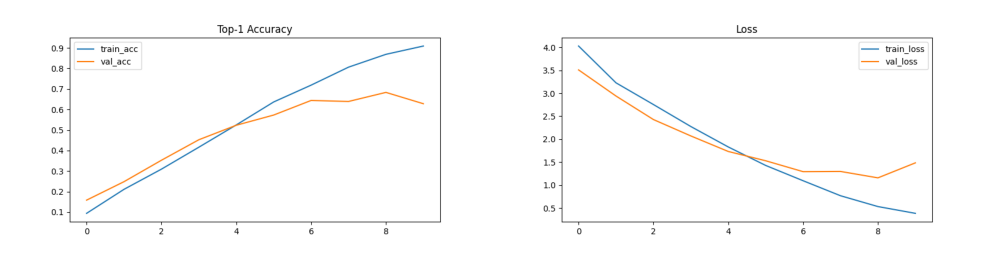

In [26]:
folder = "outputs_task1"

files = sorted([f for f in os.listdir(folder) if f.endswith("curve.png")])

rows, cols = 1,2

plt.figure(figsize=(10, 10))

for i, file in enumerate(files):
    img = Image.open(os.path.join(folder, file))
    
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()

## Saving Actication Frames

In [15]:
acts = np.stack(up_acts)               # (T_feat, H, W)
T_feat = acts.shape[0]
T_orig = frames.shape[0]

if T_feat != T_orig:
    reps = int(np.ceil(T_orig / T_feat))
    acts = np.repeat(acts, reps, axis=0)[:T_orig]

visualize_activation_on_frames(frames, acts, os.path.join(out_dir, "activation"))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0074321143..0.010631349].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0074321143..0.010631349].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0074321143..0.010773096].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0074321143..0.010631349].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0074321143..0.010702223].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0074321143..0.0104896035].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for 

## Visualizing Activation Frames

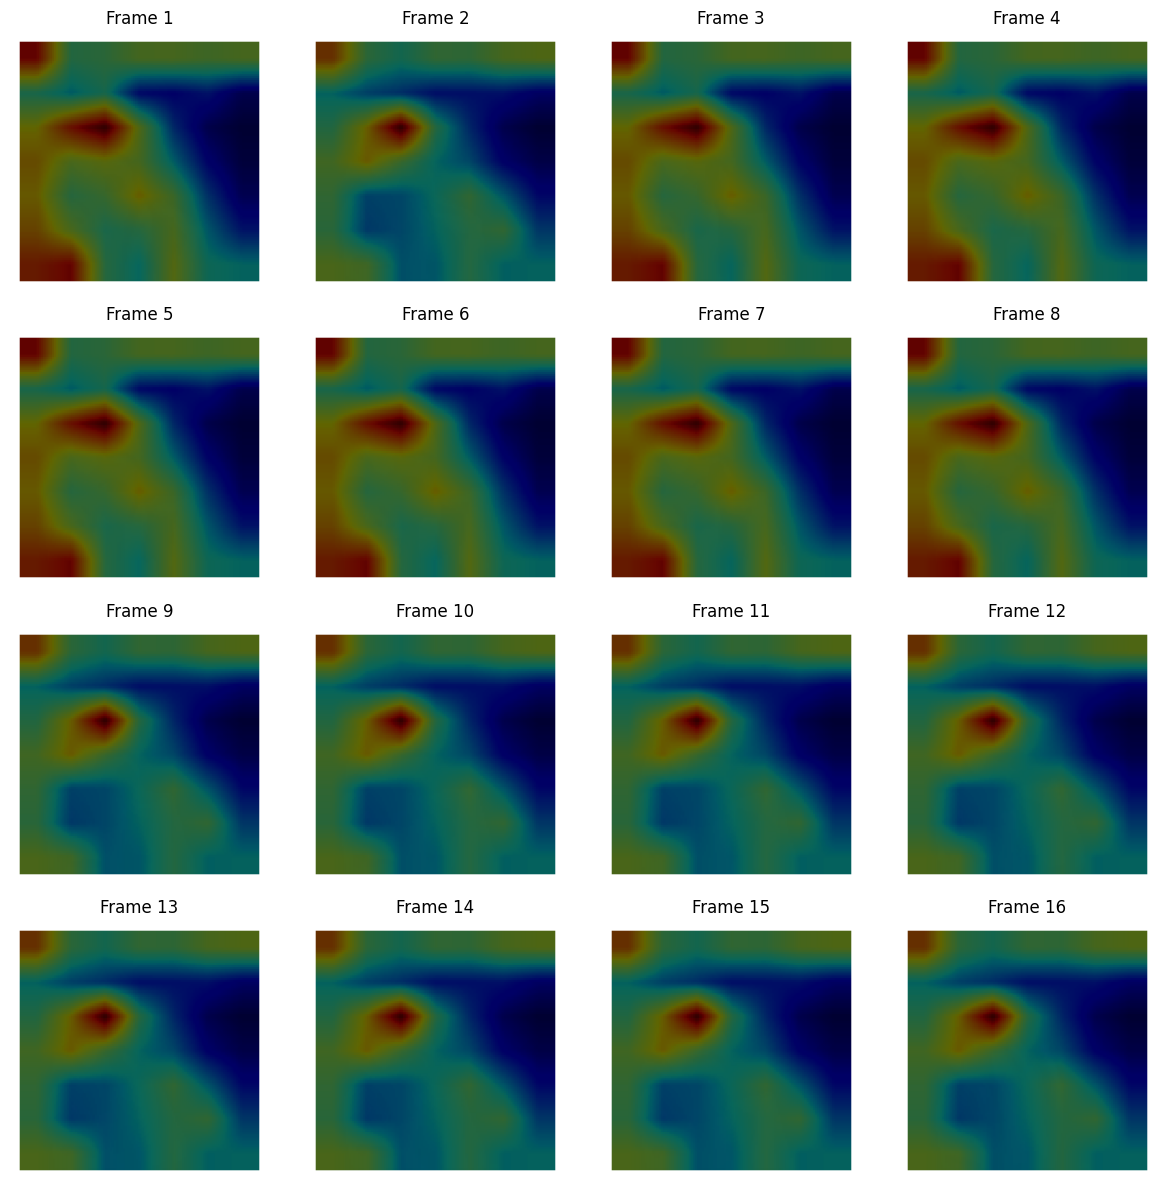

In [20]:
folder = "outputs_task1"

files = sorted([f for f in os.listdir(folder) if f.startswith("activation") if f.endswith(".png")])

rows, cols = 4, 4

plt.figure(figsize=(12, 12))

for i, file in enumerate(files):
    img = Image.open(os.path.join(folder, file))
    
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Frame {i+1}")

plt.tight_layout()
plt.show()


## Saving Model

In [18]:
torch.save({
    'model_state_dict': model.state_dict(),
    'class_to_idx': dataset.class_to_idx
}, os.path.join(out_dir, "final_model.pth"))


## Loading Back Model for testing

In [ ]:
model = torchvision.models.video.r2plus1d_18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)

checkpoint = torch.load("outputs_task1/final_model.pth", map_location=device)

model.load_state_dict(checkpoint['model_state_dict'])

model = model.to(device)
model.eval()

VideoResNet(
  (stem): R2Plus1dStem(
    (0): Conv3d(3, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
    (1): BatchNorm3d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(45, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv2Plus1D(
          (0): Conv3d(64, 144, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
          (1): BatchNorm3d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv3d(144, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
        )
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [ ]:
num_classes = len(checkpoint["class_to_idx"])

## Predicting Class

In [25]:
model.eval()
sample_x, _ = dataset[10]     # or load your own clip
sample_x = sample_x.unsqueeze(0).to(device)

with torch.no_grad():
    logits = model(sample_x)
    pred_idx = logits.argmax(1).item()

idx_to_class = {v: k for k, v in class_to_idx.items()}
print("Predicted class:", idx_to_class[pred_idx])


Predicted class: ApplyEyeMakeup


## Saving activations as GIF

In [ ]:
frames_list = []
files = sorted([f for f in os.listdir(folder) if f.startswith("activation") if f.endswith(".png")])

for file in files:
    img = imageio.imread(os.path.join(folder, file))
    frames_list.append(img)

# save GIF
output_gif = "outputs_task1/activation.gif"
imageio.mimsave(output_gif, frames_list, fps=4)

print("GIF saved at:", output_gif)


GIF saved at: outputs_task1/activation.gif


/var/folders/g2/9_y7bfxs4l7clq4gyjjn2_5m0000gn/T/ipykernel_5005/1233704195.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(os.path.join(folder, file))


## Task 1 Report – Video Action Recognition using R(2+1)D (3D CNN)

This task involved implementing and evaluating a 3D convolutional neural network for video action recognition, using the R(2+1)D architecture trained on a curated subset of the UCF101 dataset. The primary goal was to understand how spatio-temporal features can be extracted from raw video clips and assess the model’s temporal modeling capability through both quantitative metrics and qualitative activation visualizations.

Video preprocessing consisted of uniformly sampling 16 frames per video, resizing them to a fixed spatial resolution, normalizing pixel intensities, and stacking them into a (C × T × H × W) tensor. This preserves temporal continuity and enables the 3D CNN to jointly learn motion and appearance features. The R(2+1)D model was configured with a custom classification head and trained over 10 epochs using AdamW. Training accuracy increased progressively from 9.39% to 90.9%, while validation accuracy peaked at 68.3%, indicating strong learning despite the dataset’s reduced size. Loss curves show a clear downward trend initially, followed by mild overfitting after epoch 8.

To assess qualitative behavior, intermediate activations were extracted from layer4[0].conv1 and projected back onto input frames. The resulting heatmaps reveal that the model consistently focuses on regions exhibiting motion—hands, legs, body posture changes, and object interactions. This demonstrates that the network is effectively capturing temporal dependencies beyond static appearance cues.

## Temporal Modeling Effectiveness

The R(2+1)D architecture separates 3D convolutions into 2D spatial + 1D temporal components, enabling more efficient learning of motion dynamics. The model successfully identifies temporal transitions, such as movement direction, repetitive action patterns, and short-term motion cues. The increasing validation accuracy across epochs confirms its ability to extract discriminative temporal signatures.

## Temporal Modeling Limitations

However, the temporal window is restricted to 16 frames, limiting the model’s ability to understand long-range dependencies. Rapid improvements in training accuracy compared to validation accuracy suggest that the model may overfit short-term motion and struggle with complex, multi-phase actions. Additionally, temporal pooling in deeper layers compresses time steps, which may cause loss of fine-grained sequential information.

Overall, the R(2+1)D model demonstrates strong temporal modeling for short and mid-range motion but remains limited in capturing long-duration or context-dependent actions. Future work may address this by experimenting with TimeSformer or other video transformers that better preserve long-range temporal structure.